In [1]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Embedding, concatenate, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import joblib

In [2]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)

In [3]:
def clean_data(data):
    #transforming date variable
    data['date_GMT'] = pd.to_datetime(data['date_GMT'])
    data['date'] = pd.to_datetime(data['date_GMT'].dt.date)
    data['time'] = data['date_GMT'].dt.time
    
    #adding aggregated variables
    data['corners_total'] = data['home_team_corner_count'] + data['away_team_corner_count']
    data['yellow_cards_total'] = data['home_team_yellow_cards'] + data['away_team_yellow_cards']
    data['red_cards_total'] = data['home_team_red_cards'] + data['away_team_red_cards']
    data['cards_total'] = data['yellow_cards_total'] + data['red_cards_total']
    data['shots_total'] = data['home_team_shots'] + data['away_team_shots']
    data['shots_on_target_total'] = data['home_team_shots_on_target'] + data['away_team_shots_on_target']
    data['shots_off_target_total'] = data['home_team_shots_off_target'] + data['away_team_shots_off_target']
    data['fouls_total'] = data['home_team_fouls'] + data['away_team_fouls']
    
    #getting stadium names without city in brackets
    # data['base_name'] = data['stadium_name'].str.replace(r" \(.*\)$", "", regex=True)

    # city_map = data[data['stadium_name'].str.contains(r"\(.*\)")].copy()
    # city_map['city'] = city_map['stadium_name'].str.extract(r"\((.*?)\)")[0]
    # city_map = city_map.groupby('base_name')['city'].agg(pd.Series.mode).to_dict()

    # #filling stadium names without city in brackets
    # data['normalized_stadium'] = data.apply(lambda row: f"{row['base_name']} ({city_map.get(row['base_name'], 'Unknown')})" if '(' not in row['stadium_name'] else row['stadium_name'], axis=1)

    #dropping unnecessary features
    data.drop(['Unnamed: 0', 'timestamp', 'status', 'home_team_goal_timings', 'away_team_goal_timings', 'date_GMT'], axis=1, inplace=True)
    
    #setting one of the target variable - result of the game
    data['result'] = np.where(data['home_team_goal_count'] == data['away_team_goal_count'], 0, np.where(data['home_team_goal_count'] > data['away_team_goal_count'], 1, 2))
    
    def assign_season(date):
        year = date.year
        if date.month >= 8:  # Sezon zaczyna się w sierpniu
            return f'{str(year)[2:]}/{str(year+1)[2:]}'
        else:
            return f'{str(year-1)[2:]}/{str(year)[2:]}'
    
    data['season'] = data['date'].apply(assign_season)
    
    return data

In [4]:
data = pd.read_csv('./data/all_games.csv')

In [5]:
data = clean_data(data)

C:\Users\Łukasz\AppData\Local\Temp\ipykernel_7812\694537563.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['date_GMT'] = pd.to_datetime(data['date_GMT'])


# Data preprocessing

In [7]:
le = LabelEncoder()

In [8]:
data['home_team_encoded'] = le.fit_transform(data['home_team_name'])
data['away_team_encoded'] = le.fit_transform(data['away_team_name'])

In [20]:
# Przygotowanie danych wejściowych
X_home_team = data['home_team_encoded'].values
X_away_team = data['away_team_encoded'].values

# Wybrane cechy historyczne
historical_stats_columns = [
    'Pre-Match PPG (Home)', 'Pre-Match PPG (Away)', 'home_ppg', 'away_ppg',
    'home_team_goal_count', 'away_team_goal_count', 'total_goal_count', 'total_goals_at_half_time',
    'home_team_goal_count_half_time', 'away_team_goal_count_half_time', 'home_team_corner_count',
    'away_team_corner_count', 'home_team_yellow_cards', 'home_team_red_cards', 'away_team_yellow_cards',
    'away_team_red_cards', 'home_team_first_half_cards', 'home_team_second_half_cards',
    'away_team_first_half_cards', 'away_team_second_half_cards', 'home_team_shots', 'away_team_shots',
    'home_team_shots_on_target', 'away_team_shots_off_target', 'home_team_possession',
    'away_team_possession', 'Home Team Pre-Match xG', 'Away Team Pre-Match xG', 'team_a_xg', 'team_b_xg',
    'average_goals_per_match_pre_match', 'btts_percentage_pre_match', 'over_15_percentage_pre_match',
    'over_25_percentage_pre_match', 'over_35_percentage_pre_match', 'over_45_percentage_pre_match',
    'over_15_HT_FHG_percentage_pre_match', 'over_05_HT_FHG_percentage_pre_match', 'over_15_2HG_percentage_pre_match',
    'over_05_2HG_percentage_pre_match', 'average_corners_per_match_pre_match', 'average_cards_per_match_pre_match',
    'odds_ft_home_team_win', 'odds_ft_draw', 'odds_ft_away_team_win', 'odds_ft_over15', 'odds_ft_over25',
    'odds_ft_over35', 'odds_ft_over45', 'odds_btts_yes', 'odds_btts_no'
]
historical_stats = data[historical_stats_columns].values

# Przygotowanie danych wyjściowych
y_result = to_categorical(data['result'].values, num_classes=3)
y_total_goals = data['total_goal_count'].values
y_total_corners = data['corners_total'].values
y_total_cards = data['cards_total'].values

# Podział na zbiory treningowy i testowy
(X_home_team_train, X_home_team_test, 
 X_away_team_train, X_away_team_test, 
 historical_stats_train, historical_stats_test, 
 y_result_train, y_result_test, 
 y_total_goals_train, y_total_goals_test, 
 y_total_corners_train, y_total_corners_test, 
 y_total_cards_train, y_total_cards_test) = train_test_split(
    X_home_team, X_away_team, historical_stats, y_result, y_total_goals, y_total_corners, y_total_cards, 
    test_size=0.2, random_state=42)

In [59]:
y_result

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       ...,
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.]], dtype=float32)

# FCNN

In [30]:
from keras.models import Model
from keras.layers import Input, Dense, Flatten, Embedding, concatenate, Dropout
from keras.regularizers import l2

num_teams = len(le.classes_)
input_shape_stats = historical_stats_train.shape[1]

# Wejścia
home_team_input = Input(shape=(1,))
away_team_input = Input(shape=(1,))
stats_input = Input(shape=(input_shape_stats,))

# Embedding dla drużyn
home_team_embedding = Embedding(input_dim=num_teams, output_dim=32)(home_team_input)
home_team_embedding = Flatten()(home_team_embedding)

away_team_embedding = Embedding(input_dim=num_teams, output_dim=32)(away_team_input)
away_team_embedding = Flatten()(away_team_embedding)

# Połączenie wszystkich wejść
merged = concatenate([home_team_embedding, away_team_embedding, stats_input])
merged = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(merged)
merged = Dropout(0.5)(merged)
merged = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(merged)
merged = Dropout(0.5)(merged)

# Warstwy wyjściowe
result_output = Dense(3, activation='softmax', name='result')(merged)
goals_output = Dense(1, activation='relu', name='total_goals')(merged)
corners_output = Dense(1, activation='relu', name='total_corners')(merged)
cards_output = Dense(1, activation='relu', name='total_cards')(merged)

# Tworzenie modelu
model = Model(inputs=[home_team_input, away_team_input, stats_input],
              outputs=[result_output, goals_output, corners_output, cards_output])

model.compile(optimizer='adam',
              loss={'result': 'categorical_crossentropy', 'total_goals': 'mse', 'total_corners': 'mse', 'total_cards': 'mse'},
              metrics={'result': 'accuracy', 'total_goals': 'mse', 'total_corners': 'mse', 'total_cards': 'mse'})

In [31]:
history = model.fit(
    [X_home_team_train, X_away_team_train, historical_stats_train],
    {'result': y_result_train, 'total_goals': y_total_goals_train, 'total_corners': y_total_corners_train, 'total_cards': y_total_cards_train},
    epochs=50,
    batch_size=32,
    validation_split=0.2
)

Epoch 1/50
1322/1322 [==============================] - 8s 4ms/step - loss: 43.1154 - result_loss: 2.3502 - total_goals_loss: 6.1627 - total_corners_loss: 22.8576 - total_cards_loss: 10.5022 - result_accuracy: 0.3914 - total_goals_mse: 6.1627 - total_corners_mse: 22.8576 - total_cards_mse: 10.5022 - val_loss: 15.7014 - val_result_loss: 1.0697 - val_total_goals_loss: 2.9924 - val_total_corners_loss: 6.5849 - val_total_cards_loss: 3.9259 - val_result_accuracy: 0.4498 - val_total_goals_mse: 2.9924 - val_total_corners_mse: 6.5849 - val_total_cards_mse: 3.9259
Epoch 2/50
1322/1322 [==============================] - 5s 4ms/step - loss: 18.4816 - result_loss: 1.0882 - total_goals_loss: 3.0613 - total_corners_loss: 8.9033 - total_cards_loss: 4.3479 - result_accuracy: 0.4336 - total_goals_mse: 3.0613 - total_corners_mse: 8.9033 - total_cards_mse: 4.3479 - val_loss: 9.1189 - val_result_loss: 1.0608 - val_total_goals_loss: 2.2927 - val_total_corners_loss: 2.6665 - val_total_cards_loss: 2.0700 - v

# Evaluation

In [23]:
results = model.evaluate(
    [X_home_team_test, X_away_team_test, historical_stats_test],
    {'result': y_result_test, 'total_goals': y_total_goals_test, 'total_corners': y_total_corners_test, 'total_cards': y_total_cards_test}
)
print(results)

413/413 [==============================] - 1s 2ms/step - loss: 4.6770 - result_loss: 1.0353 - total_goals_loss: 0.6013 - total_corners_loss: 1.2155 - total_cards_loss: 1.3113 - result_accuracy: 0.4543 - total_goals_mse: 0.6013 - total_corners_mse: 1.2155 - total_cards_mse: 1.3113
[4.676986217498779, 1.035331130027771, 0.6013466715812683, 1.2155369520187378, 1.311293601989746, 0.454297810792923, 0.6013466715812683, 1.2155369520187378, 1.311293601989746]


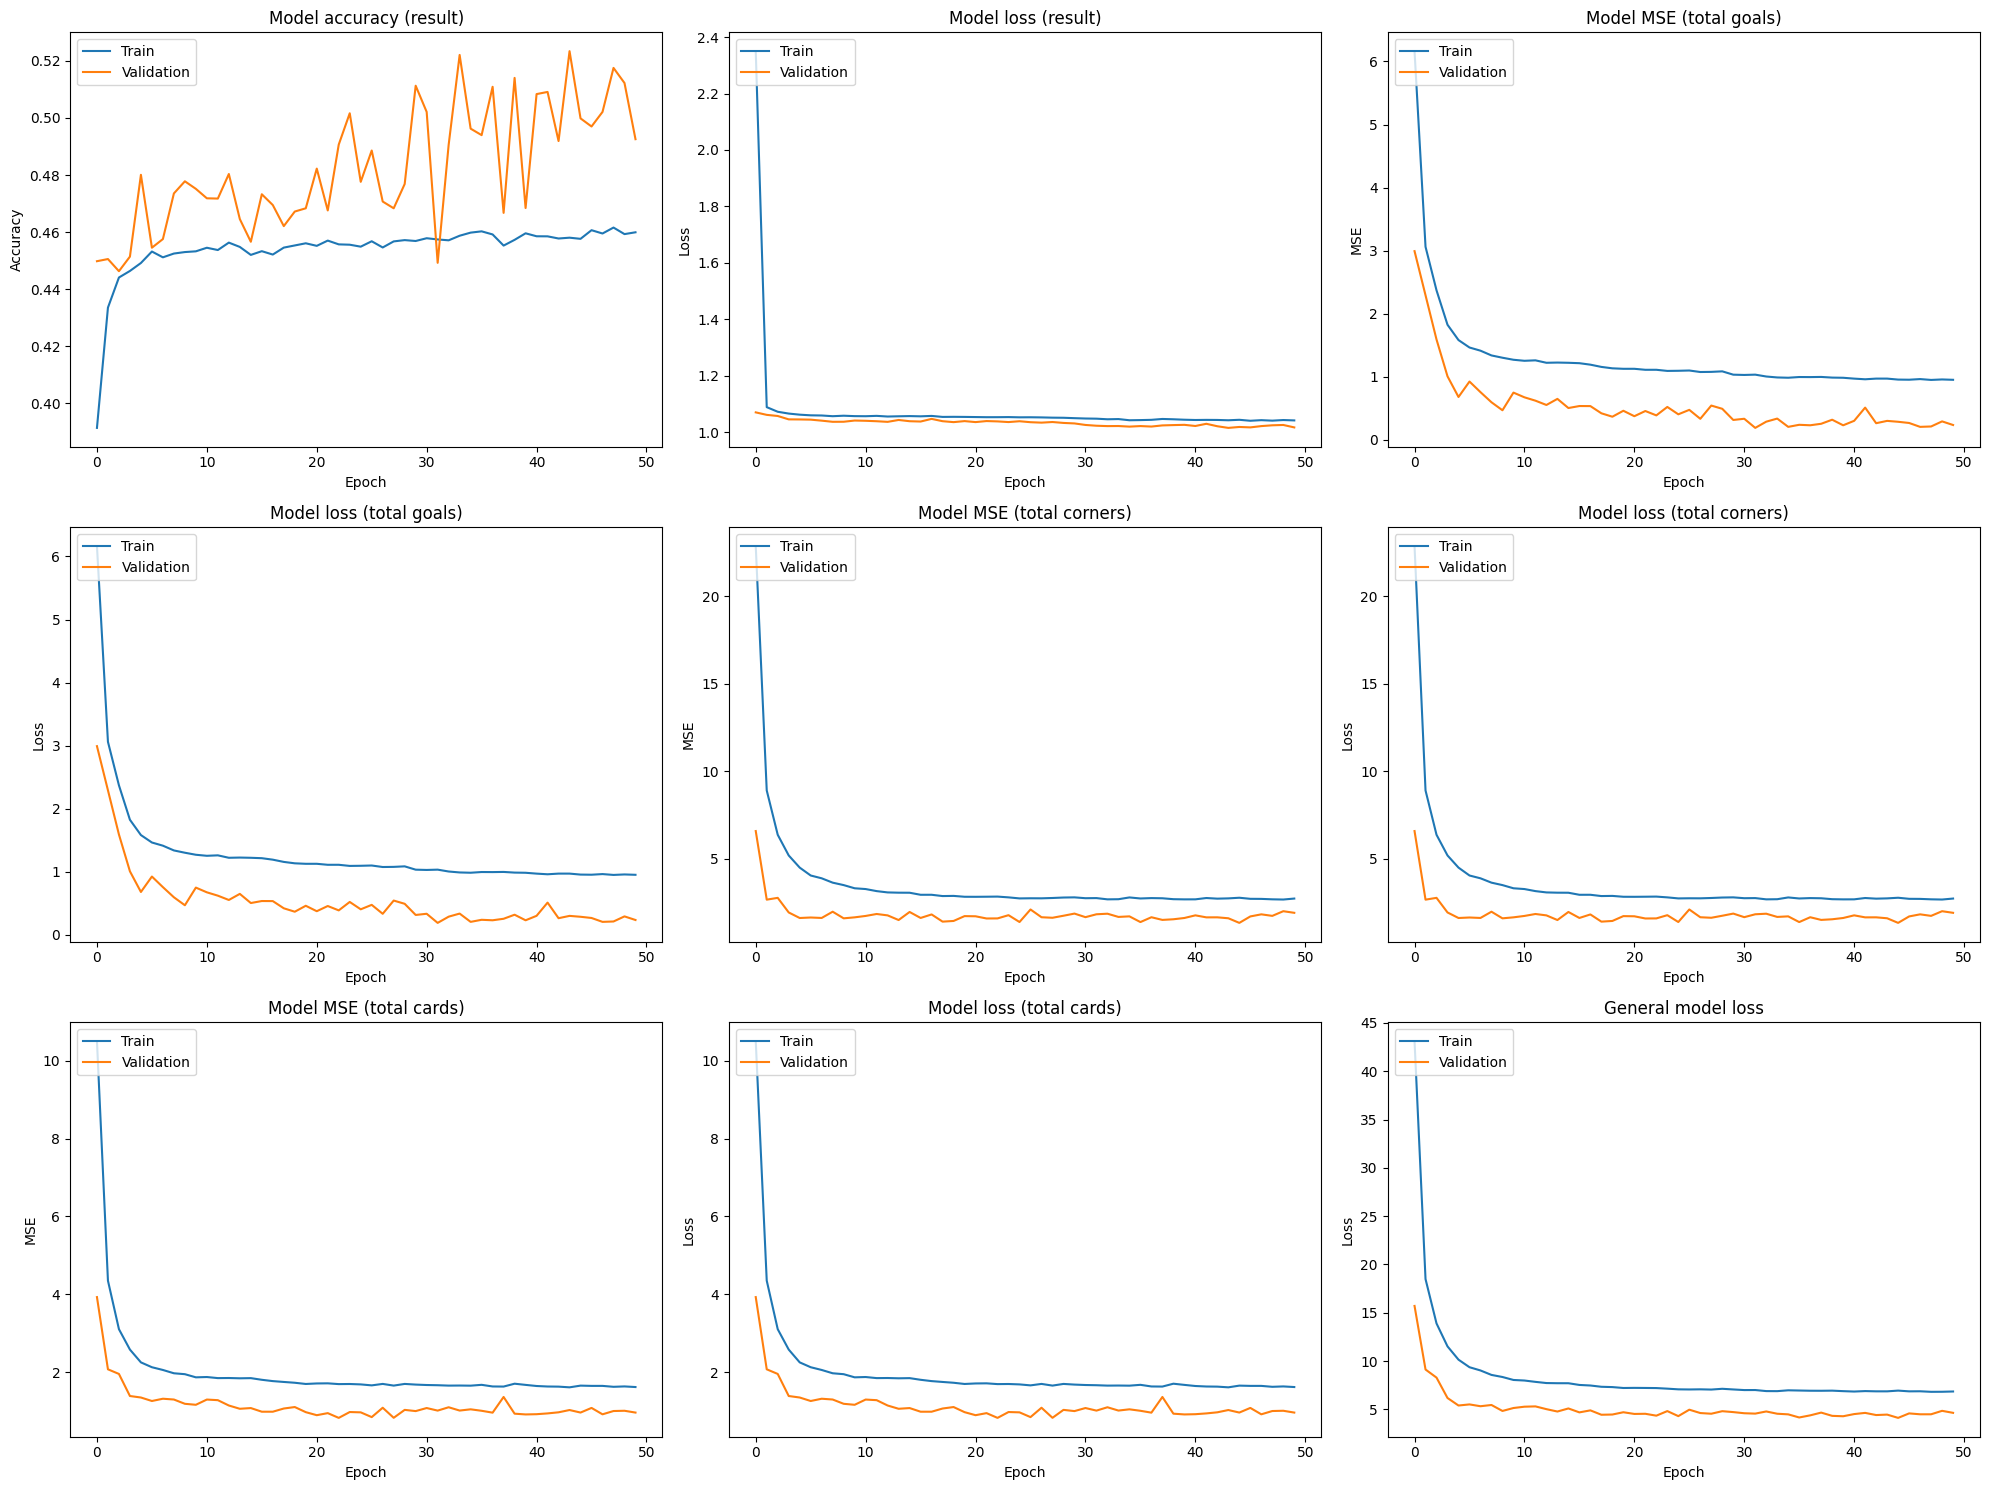

In [32]:
def visualize_training(history):
    plt.figure(figsize=(20, 15))

    # Accuracy dla wyniku
    plt.subplot(3, 3, 1)
    plt.plot(history.history['result_accuracy'])
    plt.plot(history.history['val_result_accuracy'])
    plt.title('Model accuracy (result)')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Loss dla wyniku
    plt.subplot(3, 3, 2)
    plt.plot(history.history['result_loss'])
    plt.plot(history.history['val_result_loss'])
    plt.title('Model loss (result)')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # MSE dla liczby goli
    plt.subplot(3, 3, 3)
    plt.plot(history.history['total_goals_mse'])
    plt.plot(history.history['val_total_goals_mse'])
    plt.title('Model MSE (total goals)')
    plt.ylabel('MSE')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Loss dla liczby goli
    plt.subplot(3, 3, 4)
    plt.plot(history.history['total_goals_loss'])
    plt.plot(history.history['val_total_goals_loss'])
    plt.title('Model loss (total goals)')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # MSE dla liczby rzutów rożnych
    plt.subplot(3, 3, 5)
    plt.plot(history.history['total_corners_mse'])
    plt.plot(history.history['val_total_corners_mse'])
    plt.title('Model MSE (total corners)')
    plt.ylabel('MSE')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Loss dla liczby rzutów rożnych
    plt.subplot(3, 3, 6)
    plt.plot(history.history['total_corners_loss'])
    plt.plot(history.history['val_total_corners_loss'])
    plt.title('Model loss (total corners)')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # MSE dla liczby kartek
    plt.subplot(3, 3, 7)
    plt.plot(history.history['total_cards_mse'])
    plt.plot(history.history['val_total_cards_mse'])
    plt.title('Model MSE (total cards)')
    plt.ylabel('MSE')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Loss dla liczby kartek
    plt.subplot(3, 3, 8)
    plt.plot(history.history['total_cards_loss'])
    plt.plot(history.history['val_total_cards_loss'])
    plt.title('Model loss (total cards)')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # General loss
    plt.subplot(3, 3, 9)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('General model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

# Wywołanie funkcji visualize_training
visualize_training(history)

# Predictions

In [38]:
def predict_match(model, home_team, away_team, le, input_shape_stats):
    home_team_encoded = le.transform([home_team])
    away_team_encoded = le.transform([away_team])

    historical_stats_array = np.zeros((1, input_shape_stats))  # Zero array for historical stats

    predictions = model.predict([home_team_encoded, away_team_encoded, historical_stats_array])
    
    result = np.argmax(predictions[0], axis=1)[0]
    total_goals = int(np.round(predictions[1][0][0]))
    total_corners = int(np.round(predictions[2][0][0]))
    total_cards = int(np.round(predictions[3][0][0]))

    return {'result': result, 'total_goals': max(0, total_goals), 'total_corners': max(0, total_corners), 'total_cards': max(0, total_cards)}

# Przykładowa predykcja
prediction = predict_match(model, 'Manchester United', 'Manchester City', le, input_shape_stats)
print(prediction)

1/1 [==============================] - 0s 24ms/step
{'result': 0, 'total_goals': 0, 'total_corners': 0, 'total_cards': 1}


# LSTM

## Data preprocessing

In [6]:
le = LabelEncoder()

In [ ]:
#fit transform na jednym zbiorze i zwykły transform na drugim aby uniknąć podwójnego enkodowania
data['home_team_encoded'] = le.fit_transform(data['home_team_name'])
data['away_team_encoded'] = le.transform(data['away_team_name'])

In [21]:
all_teams = list(set(np.concatenate((data['home_team_name'], data['away_team_name']))))

In [22]:
le.fit(all_teams)

LabelEncoder()

In [23]:
data['home_team_encoded'] = le.transform(data['home_team_name'])
data['away_team_encoded'] = le.transform(data['away_team_name'])

In [24]:
features = ['home_team_encoded', 'away_team_encoded', 'Pre-Match PPG (Home)', 'Pre-Match PPG (Away)', 'home_ppg', 
            'away_ppg', 'home_team_goal_count', 'away_team_goal_count', 'total_goal_count', 'total_goals_at_half_time', 
            'home_team_goal_count_half_time', 'away_team_goal_count_half_time', 'home_team_corner_count', 
            'away_team_corner_count', 'home_team_yellow_cards', 'home_team_red_cards', 'away_team_yellow_cards', 
            'away_team_red_cards', 'home_team_first_half_cards', 'home_team_second_half_cards', 
            'away_team_first_half_cards', 'away_team_second_half_cards', 'home_team_shots', 'away_team_shots', 
            'home_team_shots_on_target', 'away_team_shots_on_target', 'home_team_shots_off_target', 
            'away_team_shots_off_target', 'home_team_fouls', 'away_team_fouls', 'home_team_possession', 
            'away_team_possession', 'Home Team Pre-Match xG', 'Away Team Pre-Match xG', 'team_a_xg', 'team_b_xg', 
            'average_goals_per_match_pre_match', 'btts_percentage_pre_match', 'over_15_percentage_pre_match', 
            'over_25_percentage_pre_match', 'over_35_percentage_pre_match', 'over_45_percentage_pre_match', 
            'over_15_HT_FHG_percentage_pre_match', 'over_05_HT_FHG_percentage_pre_match', 'over_15_2HG_percentage_pre_match', 
            'over_05_2HG_percentage_pre_match', 'average_corners_per_match_pre_match', 'average_cards_per_match_pre_match', 
            'odds_ft_home_team_win', 'odds_ft_draw', 'odds_ft_away_team_win', 'odds_ft_over15', 'odds_ft_over25', 
            'odds_ft_over35', 'odds_ft_over45', 'odds_btts_yes', 'odds_btts_no']

In [25]:
# 5. Przygotowanie danych
X = data[features].values
y_result = data['result'].values
y_total_goals = data['total_goal_count'].values
y_total_corners = data['corners_total'].values
y_total_cards = data['cards_total'].values

In [26]:
# Podział danych na zestawy treningowe i testowe
X_train, X_test, y_result_train, y_result_test, y_total_goals_train, y_total_goals_test, y_total_corners_train, y_total_corners_test, y_total_cards_train, y_total_cards_test = train_test_split(
    X, y_result, y_total_goals, y_total_corners, y_total_cards, test_size=0.2, random_state=42)

In [27]:
# Sekwencje danych
sequence_length = 10

def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length + 1):
        sequences.append(data[i:i + seq_length])
    return np.array(sequences)

In [28]:
X_home_team_train_seq = create_sequences(X_train[:, 0], sequence_length)

In [32]:
X_home_team_train_seq = create_sequences(X_train[:, 0], sequence_length)
X_away_team_train_seq = create_sequences(X_train[:, 1], sequence_length)
historical_stats_train_seq = create_sequences(X_train[:, 2:], sequence_length)

y_result_train_seq = create_sequences(y_result_train, sequence_length)
y_total_goals_train_seq = create_sequences(y_total_goals_train, sequence_length)
y_total_corners_train_seq = create_sequences(y_total_corners_train, sequence_length)
y_total_cards_train_seq = create_sequences(y_total_cards_train, sequence_length)

X_home_team_test_seq = create_sequences(X_test[:, 0], sequence_length)
X_away_team_test_seq = create_sequences(X_test[:, 1], sequence_length)
historical_stats_test_seq = create_sequences(X_test[:, 2:], sequence_length)

y_result_test_seq = create_sequences(y_result_test, sequence_length)
y_total_goals_test_seq = create_sequences(y_total_goals_test, sequence_length)
y_total_corners_test_seq = create_sequences(y_total_corners_test, sequence_length)
y_total_cards_test_seq = create_sequences(y_total_cards_test, sequence_length)

## Model

In [33]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Embedding, concatenate, LSTM, Dropout
from tensorflow.keras.optimizers import Adam

# 6. Tworzenie modelu LSTM
num_teams = len(le.classes_)
input_shape_stats = historical_stats_train_seq.shape[2]

# Wejścia
home_team_input = Input(shape=(sequence_length,))
away_team_input = Input(shape=(sequence_length,))
stats_input = Input(shape=(sequence_length, input_shape_stats))

# Embedding dla drużyn
home_team_embedding = Embedding(input_dim=num_teams, output_dim=32)(home_team_input)
away_team_embedding = Embedding(input_dim=num_teams, output_dim=32)(away_team_input)

# LSTM dla sekwencji wyników drużyn
home_team_lstm = LSTM(32, return_sequences=False)(home_team_embedding)
away_team_lstm = LSTM(32, return_sequences=False)(away_team_embedding)

# LSTM dla historycznych statystyk
stats_lstm = LSTM(64, return_sequences=False)(stats_input)

# Połączenie wszystkich wejść
merged = concatenate([home_team_lstm, away_team_lstm, stats_lstm])
merged = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(merged)
merged = Dropout(0.5)(merged)
merged = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(merged)
merged = Dropout(0.5)(merged)

# Warstwy wyjściowe
result_output = Dense(3, activation='softmax', name='result')(merged)
goals_output = Dense(1, activation='relu', name='total_goals')(merged)
corners_output = Dense(1, activation='relu', name='total_corners')(merged)
cards_output = Dense(1, activation='relu', name='total_cards')(merged)

# Tworzenie modelu
model = Model(inputs=[home_team_input, away_team_input, stats_input],
              outputs=[result_output, goals_output, corners_output, cards_output])

model.compile(optimizer=Adam(),
              loss={'result': 'sparse_categorical_crossentropy', 'total_goals': 'mse', 'total_corners': 'mse', 'total_cards': 'mse'},
              metrics={'result': 'accuracy', 'total_goals': 'mse', 'total_corners': 'mse', 'total_cards': 'mse'})

## Trening

In [34]:
# 7. Trening modelu
history = model.fit(
    [X_home_team_train_seq, X_away_team_train_seq, historical_stats_train_seq],
    {'result': y_result_train_seq[:, -1], 'total_goals': y_total_goals_train_seq[:, -1], 'total_corners': y_total_corners_train_seq[:, -1], 'total_cards': y_total_cards_train_seq[:, -1]},
    epochs=50,
    batch_size=32,
    validation_split=0.2
)

Epoch 1/50


1322/1322 [==============================] - 18s 8ms/step - loss: 20.7909 - result_loss: 1.1857 - total_goals_loss: 3.5185 - total_corners_loss: 10.2287 - total_cards_loss: 4.7418 - result_accuracy: 0.4041 - total_goals_mse: 3.5185 - total_corners_mse: 10.2287 - total_cards_mse: 4.7418 - val_loss: 7.4240 - val_result_loss: 1.0669 - val_total_goals_loss: 2.7971 - val_total_corners_loss: 1.5456 - val_total_cards_loss: 1.1913 - val_result_accuracy: 0.4517 - val_total_goals_mse: 2.7971 - val_total_corners_mse: 1.5456 - val_total_cards_mse: 1.1913
Epoch 2/50
1322/1322 [==============================] - 9s 7ms/step - loss: 10.9649 - result_loss: 1.0663 - total_goals_loss: 2.4583 - total_corners_loss: 4.5994 - total_cards_loss: 2.1122 - result_accuracy: 0.4461 - total_goals_mse: 2.4583 - total_corners_mse: 4.5994 - total_cards_mse: 2.1122 - val_loss: 5.1275 - val_result_loss: 1.0461 - val_total_goals_loss: 0.9835 - val_total_corners_loss: 1.5513 - val_total_cards_loss: 0.8729 - v

## Metrics

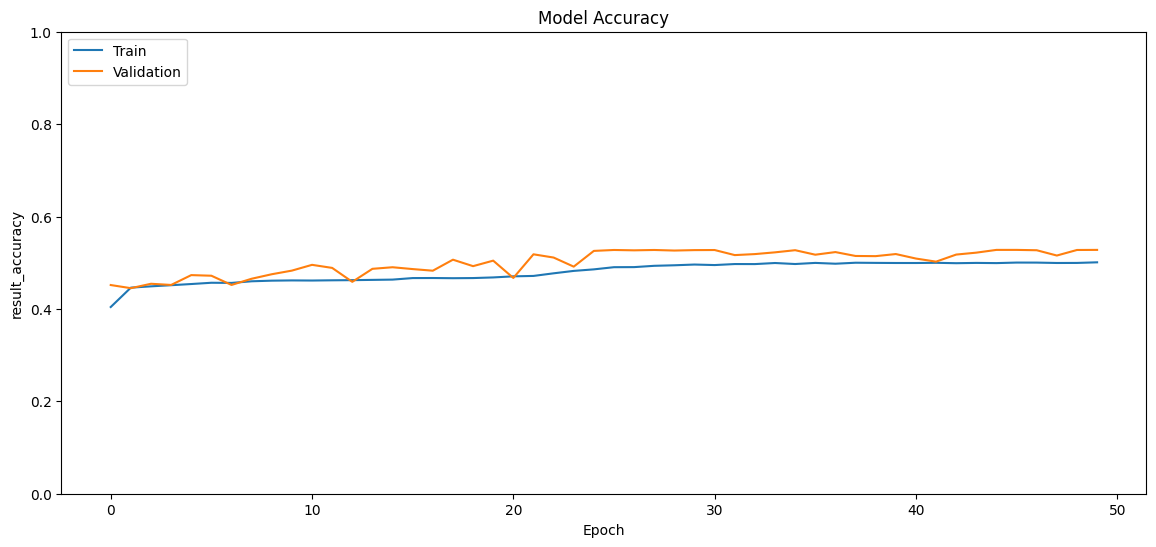

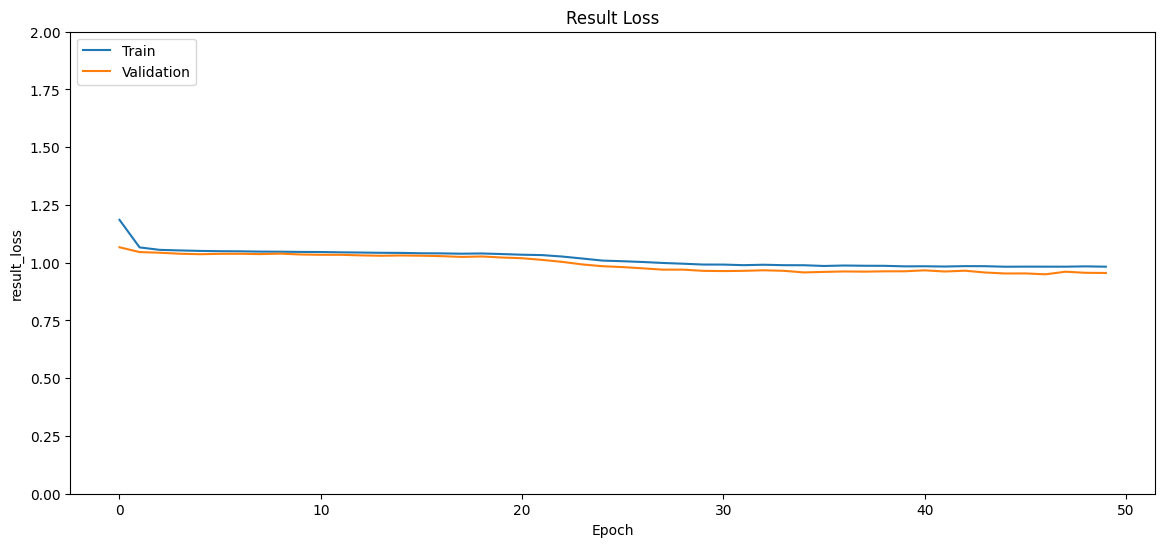

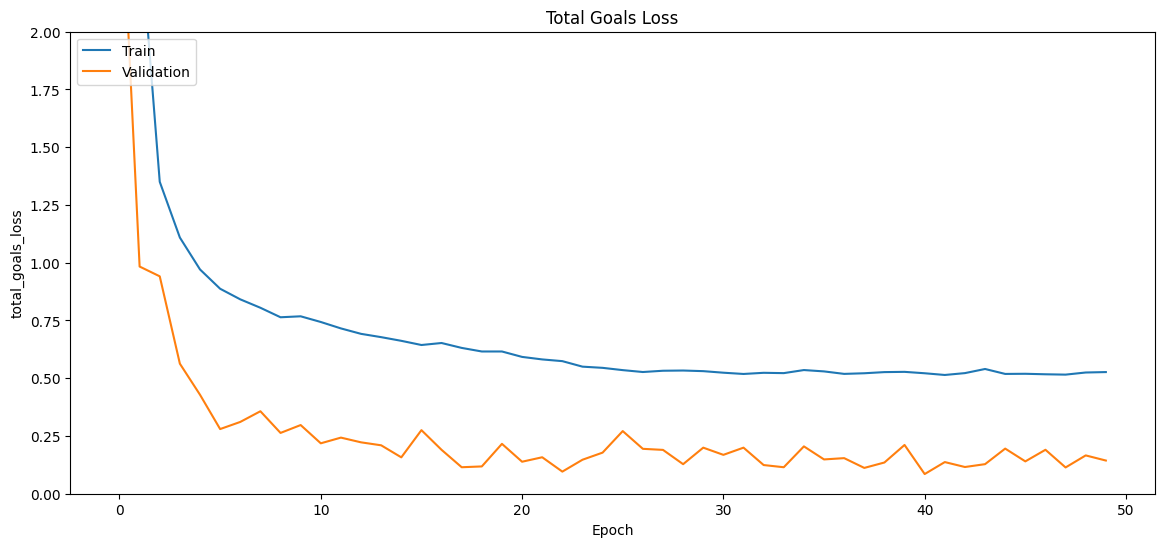

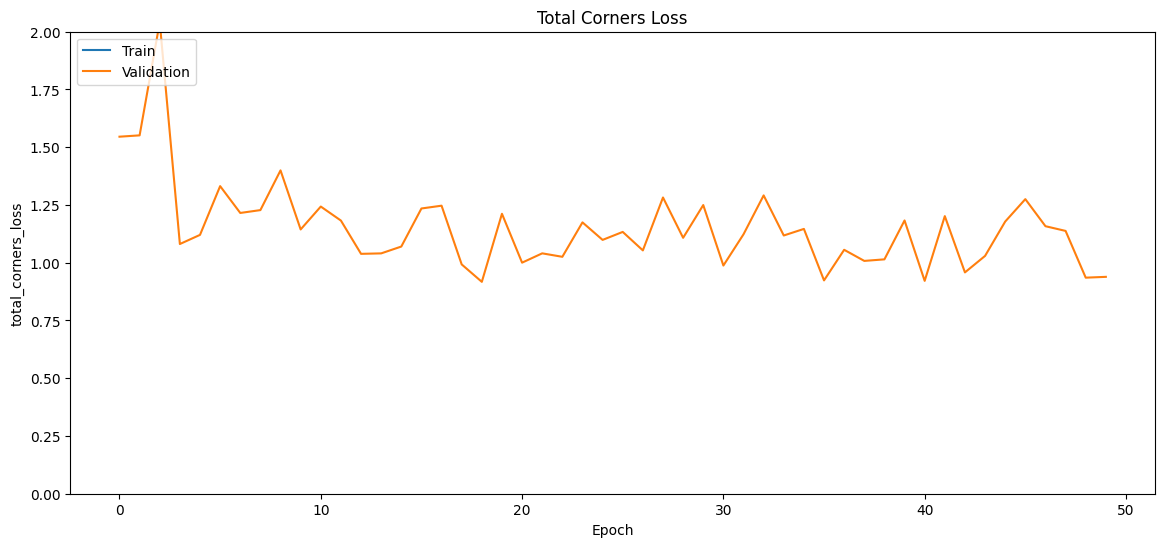

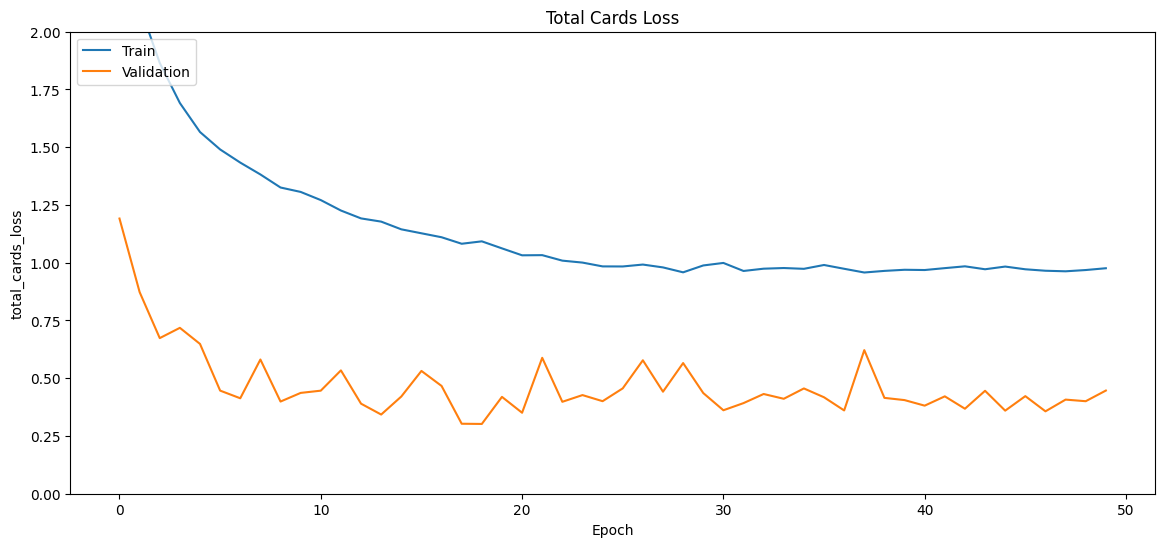

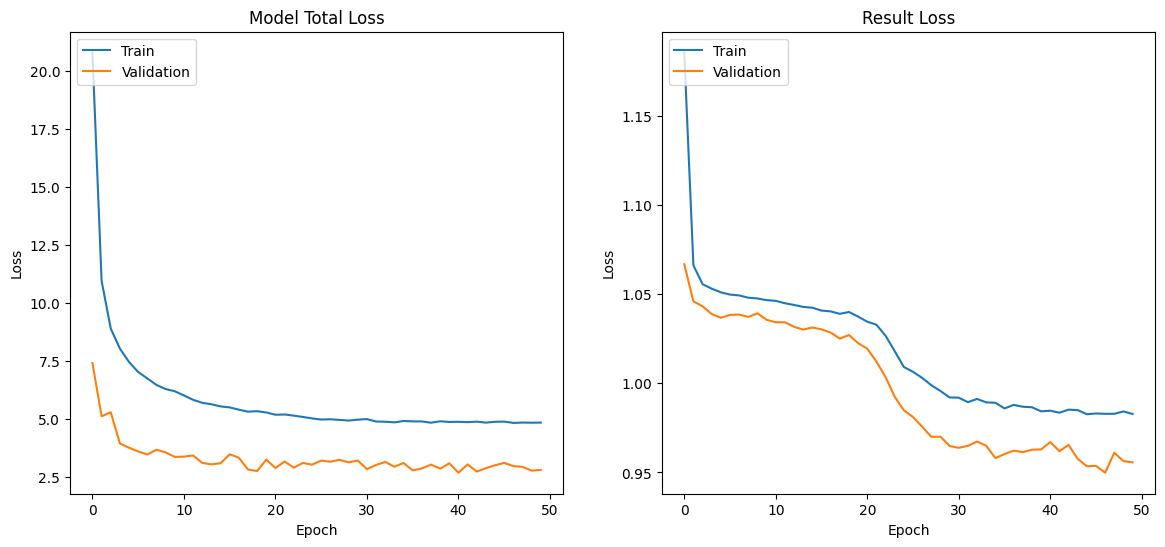

In [35]:
# Wizualizacja metryk

def plot_metrics(history, metric_name, title, ylim=5):
    plt.figure(figsize=(14, 6))
    plt.plot(history.history[metric_name])
    plt.plot(history.history['val_' + metric_name])
    plt.title(title)
    plt.ylabel(metric_name)
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.ylim(0, ylim)
    plt.show()

# Wizualizacja wyników treningu
plot_metrics(history, 'result_accuracy', 'Model Accuracy', ylim=1)
plot_metrics(history, 'result_loss', 'Result Loss', ylim=2)
plot_metrics(history, 'total_goals_loss', 'Total Goals Loss', ylim=2)
plot_metrics(history, 'total_corners_loss', 'Total Corners Loss', ylim=2)
plot_metrics(history, 'total_cards_loss', 'Total Cards Loss', ylim=2)

# Wizualizacja ogólnych strat
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Total Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['result_loss'])
plt.plot(history.history['val_result_loss'])
plt.title('Result Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()
